<div align="center">

![hou](https://datahack-prod.s3.ap-south-1.amazonaws.com/__sized__/contest_cover/is_this_funny-thumbnail-1200x1200-70.jpg)

</div>

Nesta competição da Analytics Vidhya temos que prever notas que são atribuidas a piadas, vamos cria um modelo de recomendação (**RecSys**). Para validarmos o modelo vou utilizar a métrica **RMSE** estipulada pela competição.

<p align="center">
    <img width="700" height="250" src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*kgBD8OuP7SMsL63gcsQ90Q.png">
</p>

Os exemplos são diversos: a Amazon recomenda livros (ou qual coisa do marketplace), a Netflix faz recomendação de Filmes, o Mendeley recomenda artigos ciêntíficos, a Globo.com recomenda notícias e o Spotify às músicas.

*   Temos algumas opções de algoritimos de Machine Learning para RecSys.

    *   Filtragem Baseada em Conteúdo (Content-Based)
    *   Filtragem Colaborativa (Collaborative Filter)
    *   Sistemas Híbridos (Hybrid)
    *   Cold-Start

Aqui não abordarei as vantagens e desvatagens deles, na seção Modelo onde criaremos nossa máquina preditiva, abordarei um pouco sobre a escolha realizada.

In [98]:
# Importando bibliotecas.
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from skopt.callbacks import EarlyStopper

from scipy import stats
from statistics import stdev, mean

from surprise import Reader, Dataset, accuracy, SVD
from surprise.model_selection import KFold, train_test_split, cross_validate
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")
#pd.set_option("display.max_columns", None)
#pd.set_option("display.max_rows", None)

# Análise Exploratória
Aqui iremos realizar uma breve exploração de nossos dados, demostrar algumas estáticas. Nosso dataset já é conhecido, temos apenas quatro features e nossa variável alvo é a Rating(nota) atribuida pelos usuários às piadas.

* **Arquivos**

    *   train.csv - arquivo destinano para treino e teste.
    *   test.csv - arquivo que será usado para criar o submission.csv, e enviaremos as previsões do modelo.

In [6]:
# Importando dados
dados = pd.read_csv("dados/train.csv")
valid = pd. read_csv("dados/test.csv")
jokes = pd.read_csv("dados/jokes.csv")

In [7]:
# Dataset de treino.
dados.head()

,id,user_id,joke_id,Rating
0,31030_110,31030,110,2.750
1,16144_109,16144,109,5.094
2,23098_6,23098,6,-6.438
3,14273_86,14273,86,4.406
4,18419_134,18419,134,9.375


In [8]:
# Dataset de teste.
valid.head()

,id,user_id,joke_id
0,6194_11,6194,11
1,19356_3,19356,3
2,23426_79,23426,79
3,40030_3,40030,3
4,19806_115,19806,115


In [9]:
dados.shape, valid.shape

((1092059, 4), (537880, 3))

In [10]:
# Verificando algumas informações do nosso dataset.
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092059 entries, 0 to 1092058
Data columns (total 4 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   id       1092059 non-null  object 
 1   user_id  1092059 non-null  int64  
 2   joke_id  1092059 non-null  int64  
 3   Rating   1092059 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 33.3+ MB


Podemos verificar que nossa variável alvo(target), já assume um valor do tipo numérico, e não encontramos valores ausentes em nosso dataset.

## Estátisticas
Aqui vamos verificar algumas medidas de posisão e dispersão....

In [11]:
# Média, desvio padrão amostral e variança amostral da feature Rating
print("Média Rating:", mean(dados.Rating))
print("Desvio Padrão Rating:", stdev(dados.Rating))
print("Valor Min. Rating:", min(dados.Rating))
print("Valor Max. Rating:", max(dados.Rating))

Média Rating: 1.7583939732193956
Desvio Padrão Rating: 5.2308597557955006
Valor Min. Rating: -10.0
Valor Max. Rating: 10.0


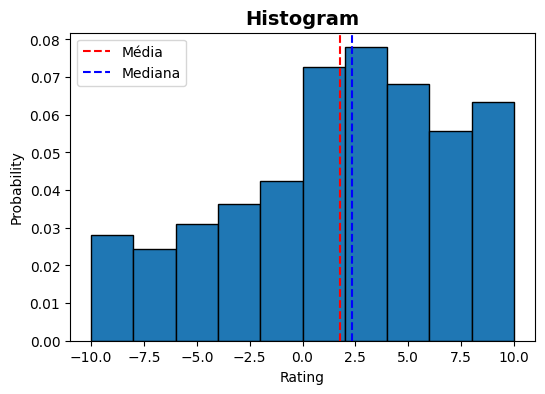

In [12]:
# Histograma da nossa variável alvo Rating.
plt.figure(figsize=(6, 4))
plt.hist(dados.Rating, density=True, edgecolor="black")
plt.title("Histogram", fontweight="bold", fontsize=14)
plt.xlabel("Rating")
plt.ylabel("Probability")
plt.axvline(dados.Rating.mean(), color="red", linestyle="--")
plt.axvline(dados.Rating.median(), color="blue", linestyle="--")
plt.legend(title="", labels=["Média","Mediana"], ncol=1, loc="best")
#plt.spines['right'].set_visible(False)
#plt.spines['top'].set_visible(False)
plt.show()

In [99]:
# Realisando teste de Shapiro-Wilk, onde verificamos se às variáveis segue uma distribuição normal.
print(stats.shapiro(dados.Rating))

ShapiroResult(statistic=0.9625284671783447, pvalue=0.0)


Com nosso histograma e o teste de Shapiro Wilk podemos verificar que nosso alvo não segue uma distribuição normal. Para o teste realizado temos um p-value menor que 0.05, com intervalo de confiança de 95% e meu alfa de 5%, devo rejeita minha hipótese nula (H0) de que a variável Rating seguem uma distribuição normal e aceita a hipótese alternativa (Ha) de que meus dados não tem uma distribuição normal.

# Tratamento dos Dados
Nesta seção realizamos procedimentos como feature scaling, feature engineer, select feature entre outros, tudo isso a fim de encontrarmos um padão nos dados. Iremos utilizar alguns desses recursos de acordo com o desenvolvimento e resultados que vamos obtendo.

## Split dos Dados
Neste caso vou dar preferência por utilizar Hod-Out, para realizar o split em uma proporção de 80% para treino e 20% para teste.

In [80]:
# Realizando split dos dados entre treino e teste.
reader = Reader(rating_scale=(-10., 10.))
data = Dataset.load_from_df(dados[["user_id", "joke_id", "Rating"]], reader)
X_train, X_test = train_test_split(data, test_size=0.2, random_state=0)

# Modelos
Utilizando à biblioteca [_**Surprise**_](https://surpriselib.com/), irei cria alguns modelos utilizando **SVD** _(Singular Value Decomposition)_, _Filtragem Colaborativa_.

A Filtragem Colaborativa ignora as características do conteúdo e foca na interação entre o Usuário X Conteúdo. Parte do princípio que o sistema não precisa saber as características do conteúdo, mas sim quais conteúdos o usuário consumiu para identificar quais outros usuários tiveram o mesmo comportamento de consumo. Dessa forma é possível “trocar” recomendações entre usuários semelhantes ao processar o coletivo.

<div align="center">

![hou](https://miro.medium.com/v2/resize:fit:638/format:webp/0*e3_p3-HIh8DCin4m)

</div>

O **SVD** realiza a fatoração de matrizes, isso pode ser um problema quando temos muitos dados, pois às matrizes seram muito esparsas, isso resultarar em custo computacional muito alto levando muito tempo de processamento. Mas vamos em frente....

$$
\begin{align} 
\hat r_i = \mu + b_u + b_i + q_i^T p_u
\end{align}
$$

## Modelo inicial
Crindo modelo utilizando parâmetros default, vamos obter nossa RMSE e trabalhar para melhorar nossa métrica.

In [74]:
# Criando modelo.    
model_svd = SVD()
# Treinando o modelo.
model_svd.fit(X_train)
# Realizando previsões.
predic = model_svd.test(X_test)

round(accuracy.rmse(predic, verbose=False),10)

4.2825453692

Primeira tentativa treinamos o modelo sem trabalhar parâmetros, hiperparâmetros ou qualquer técnica, o default mesmo.

In [75]:
# Trabalhando com aleatoriedade, criar um modelo e treina-lo por n vezes onde vamos 
# trocar a rando_state, usando numeros pares até sed 100, e ober a melhor sed.
mrmse = []

for rand_sed in range(2,61,2):
    # Criando modelo.
    model_svd = SVD(random_state=rand_sed)
    # Treinando o modelo.
    model_svd.fit(X_train)
    # Realizando previsões.
    predic = model_svd.test(X_test)
    result = round(accuracy.rmse(predic, verbose=False),10)
    mrmse.append((result, rand_sed))

print('Melhor resultado:', min(mrmse))

Melhor resultado: (4.2755483293, 40)


Nesta tentativa já utilizando alguma técnica, nesse caso trabalhei à aleatoriedade e já obtivemos um melhor resultado, uma RMSE de 4.2755 com uma sed 40. 

# Otimização do Modelo
Utilizando [**scikit-optimize**](https://scikit-optimize.github.io/stable/index.html) Bayesian optimization, na tentativa de otimizar o modelo, tuning dos hiperparâmetros.

In [83]:
# Parâmetros usados pela nossa função de otimização, que serão passados para o modelo.
space = [
    Integer(500, 650, name="n_factors"),
    Integer(100, 250, name="n_epochs"),
    Real(1e-3, 1e-1, "log-uniform", name="lr_bu"),
    Real(1e-3, 1e-1, "log-uniform", name="lr_bi"),
    Real(1e-3, 1e-1, "log-uniform", name="lr_pu"),
    Real(1e-3, 1e-1, "log-uniform", name="lr_qi"),
    Real(1e-3, 1e-1, "log-uniform", name="reg_bu"),
    Real(1e-3, 1e-1, "log-uniform", name="reg_bi"),
    Real(1e-3, 1e-1, "log-uniform", name="reg_pu"),
    Real(1e-3, 1e-1, "log-uniform", name="reg_qi")
]

@use_named_args(space)
def svd_bayesian(**params):
    """ 
    Função para criação do modelo que recebe os parâmetros (lr_bu, lr_bi, lr_pu, lr_qi, reg_bu, reg_bi, reg_pu e reg_qi), 
    por meio da função de otimização.
    """
    model_svd = SVD(**params, verbose=False, random_state=10)
    model_svd.fit(X_train)
    predic = model_svd.test(X_test)
    result = round(accuracy.rmse(predic), 10)

    return result

In [84]:
# Função de Otimização.
res_gp = gp_minimize(
    func=svd_bayesian, 
    dimensions=space,
    n_initial_points=5, 
    n_calls=15,
    verbose=False, 
    random_state=10
)

print('\n')
print('Best RMSE: %.10f' % (res_gp.fun)) 
print('Best Parameters: %s' % (res_gp.x))

RMSE: 4.0566
RMSE: 4.1420
RMSE: 4.0271
RMSE: 4.1275
RMSE: 4.1607
RMSE: 4.0515
RMSE: 9.7514
RMSE: 4.1685
RMSE: 4.0465
RMSE: 4.0128
RMSE: 4.1206
RMSE: 4.1155
RMSE: 4.0424
RMSE: 4.0855
RMSE: 4.0439


Best RMSE: 4.0128003969
Best Parameters: [596, 180, 0.1, 0.0017002075549700914, 0.060833357287746435, 0.001, 0.005828169714153822, 0.001225388190176047, 0.0012775443300217363, 0.1]


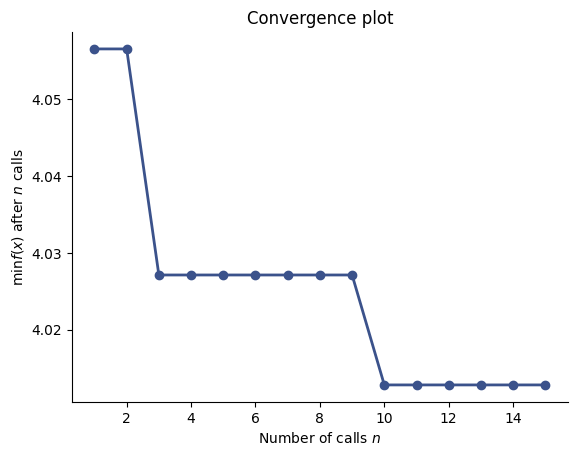

In [85]:
fig, ax = plt.subplots()
plot_convergence(res_gp)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)
plt.show()

Com o gráfico podemos observar que na execução 10 em diante não conseguimos ganhos siguinificativos. 

## Cross-Validation
Crindo o modelo com os hiperparâmetros encontrados pela função de otimização **gp_minimize**, para realizar Cross-Validation, após várias execuções estes foram os hiperparâmetros com melhor resultado.

In [92]:
# Criando modelo.    
model_svd = SVD(
    n_factors=500,
    n_epochs=238,
    lr_bu=0.036486316612493984,
    lr_bi=0.001,
    lr_pu=0.05272355080621753,
    lr_qi=0.0013008168848494819,
    reg_bu=0.001,
    reg_bi=0.0012862491471839173,
    reg_pu=0.001,
    reg_qi=0.0757888905856779,
    random_state=10
)
model_svd.fit(X_train)
predic = model_svd.test(X_test)

round(accuracy.rmse(predic, verbose=False),10)

4.0125360492

In [93]:
mrmse = []
kfold = 0
kf = KFold(n_splits=50, random_state=10)

In [94]:
# Realizando cross-validation.
for trainset, testset in kf.split(data):
    model_svd.fit(trainset)
    predic = model_svd.test(testset)
    result = round(accuracy.rmse(predic, verbose=False),10)
    mrmse.append(result)
    kfold += 1
    print("Fold:", kfold, "RMSE:", result)
    
print("Média RMSE CV", mean(mrmse))

Fold: 1 RMSE: 4.0104065999
Fold: 2 RMSE: 3.9917042982
Fold: 3 RMSE: 3.9704787179
Fold: 4 RMSE: 3.9835107152
Fold: 5 RMSE: 3.9686864282
Fold: 6 RMSE: 3.9673279231
Fold: 7 RMSE: 3.9553324196
Fold: 8 RMSE: 3.9553042203
Fold: 9 RMSE: 3.9850496718
Fold: 10 RMSE: 3.9672842253
Fold: 11 RMSE: 4.0101036394
Fold: 12 RMSE: 3.9433609822
Fold: 13 RMSE: 3.9726168409
Fold: 14 RMSE: 3.9693719892
Fold: 15 RMSE: 3.9667936264
Fold: 16 RMSE: 4.0079733217
Fold: 17 RMSE: 3.9918671217
Fold: 18 RMSE: 3.9837636038
Fold: 19 RMSE: 4.0195435416
Fold: 20 RMSE: 3.9732015076
Fold: 21 RMSE: 3.9655615259
Fold: 22 RMSE: 3.9492067023
Fold: 23 RMSE: 4.002059642
Fold: 24 RMSE: 3.9336401516
Fold: 25 RMSE: 3.9959853109
Fold: 26 RMSE: 4.0092616192
Fold: 27 RMSE: 4.0097371169
Fold: 28 RMSE: 3.9869084831
Fold: 29 RMSE: 4.0055975596
Fold: 30 RMSE: 3.9642241581
Fold: 31 RMSE: 3.9654077376
Fold: 32 RMSE: 3.9965907677
Fold: 33 RMSE: 3.9760326663
Fold: 34 RMSE: 3.98695124
Fold: 35 RMSE: 4.0124308998
Fold: 36 RMSE: 3.9793272432
Fold

Nossa RMSE da média de nossa cross-validation foi de 3.981784901286, este é nosso resultado final, para nosso submission.

In [65]:
@use_named_args(space)
def svd_bayesian_cv(**params):
    """ 
    
    """
    kfold = 0
    mrmse.clear()
    model_svd_cv_gp = SVD(**params, verbose=False, random_state=10)

    for trainset, testset in kf.split(data):
        model_svd_cv_gp.fit(trainset)
        predic = model_svd_cv_gp.test(testset)
        result = round(accuracy.rmse(predic, verbose=False),10)
        mrmse.append(result)
        kfold += 1
        print("Fold:", kfold, "RMSE:", result)
    
    print("Média RMSE CV", mean(mrmse), "\n")
    return min(mrmse)

In [ ]:
# Gaussian processes
res_gp_cv = gp_minimize(
    func=svd_bayesian_cv, 
    dimensions=space,
    n_initial_points=5, 
    n_calls=5,
    verbose=False, 
    random_state=10
)

print('Best RMSE: %.10f' % (res_gp_cv.fun)) 
print('Best Parameters: %s' % (res_gp_cv.x))

## Submission
Realizando predição para envio (submission).

In [96]:
# Realizando predição com dados de validação, para submission.
pred = []

for i in trange(valid.shape[0]):
    pred.append((valid.iloc[i, 0], model_svd.predict(valid.iloc[i, 1], valid.iloc[i, 2])[3]))

100%|██████████| 537880/537880 [01:31<00:00, 5891.54it/s]


In [97]:
# Gerando CSV submission.
sub = pd.DataFrame(pred, columns=["id", "Rating"])
sub.to_csv("submission.csv", index=False)